In [1]:
%matplotlib inline
import pydicom
import numpy as np # linear algebra
import os
import open3d as o3d
import scipy
import matplotlib.pyplot as plt
import copy
import pandas as pd

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# dicomdir_path="/home/qiwen/Documents/CT_Daten/Case WM/2023-08-24-002/DICOMDIR"
# images_folder="/home/qiwen/Documents/CT_Daten/Case WM/2023-08-24-002/IMAGES"

df = pd.read_excel('/home/qiwen/Documents/CT_Daten/Points and definitions.xlsx', sheet_name='Case RS')
dicomdir_path='/home/qiwen/Documents/CT_Daten/Case RS/2023-08-24-001/DICOMDIR'
images_folder="/home/qiwen/Documents/CT_Daten/Case RS/2023-08-24-001/IMAGES"
target_study_id="8ac05771"
target_SeriesNumber="301"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dicomdir = pydicom.dcmread(dicomdir_path)

# 查看DICOMDIR中的患者信息
for patient_record in dicomdir.patient_records:
    print(f"Patient ID: {patient_record.PatientID}")
    print(f"Patient Name: {patient_record.PatientName}")

    # 获取该患者的所有影像记录
    studies = patient_record.children
    for study in studies:
        print(f"Study Date: {study.StudyDate}")
        print(f"Study Description: {study.StudyDescription}")

        # 获取影像序列记录
        series = study.children
        for serie in series:
            print(f"Series Description: {serie.SeriesDescription}")
            print(f"Modality: {serie.Modality}")
            
            # 获取每个序列中的所有影像文件
            instances = serie.children
            for instance in instances:
                print(f"Instance File: {instance.ReferencedFileID}")


Patient ID: 2f28988d
Patient Name: De-identified
Study Date: 20220323
Study Description: CT NNH,Kiefer Nativ
Series Description: Scout
Modality: CT
Instance File: ['IMAGES', 'IM00001']
Instance File: ['IMAGES', 'IM00002']
Series Description: 0.625mm WT Gesichtsschädel
Modality: CT
Instance File: ['IMAGES', 'IM00003']
Instance File: ['IMAGES', 'IM00004']
Instance File: ['IMAGES', 'IM00005']
Instance File: ['IMAGES', 'IM00006']
Instance File: ['IMAGES', 'IM00007']
Instance File: ['IMAGES', 'IM00008']
Instance File: ['IMAGES', 'IM00009']
Instance File: ['IMAGES', 'IM00010']
Instance File: ['IMAGES', 'IM00011']
Instance File: ['IMAGES', 'IM00012']
Instance File: ['IMAGES', 'IM00013']
Instance File: ['IMAGES', 'IM00014']
Instance File: ['IMAGES', 'IM00015']
Instance File: ['IMAGES', 'IM00016']
Instance File: ['IMAGES', 'IM00017']
Instance File: ['IMAGES', 'IM00018']
Instance File: ['IMAGES', 'IM00019']
Instance File: ['IMAGES', 'IM00020']
Instance File: ['IMAGES', 'IM00021']
Instance File: 

In [3]:
print(dicomdir)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Media Storage Directory Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.45.1.7.4.929342982293.23082415220500001.11292
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.45.1.1.0.71.20130122
(0002, 0013) Implementation Version Name         SH: 'DicomWeb_71'
-------------------------------------------------
(0004, 1130) File-set ID                         CS: 'VISAGECS_MEDIA'
(0004, 1200) Offset of the First Directory Recor UL: 404
(0004, 1202) Offset of the Last Directory Record UL: 404
(0004, 1212) File-set Consistency Flag           US: 0
(0004, 1220)  Directory Record Sequence  1161 item(s) ---- 
   (0004, 1400) Offset of the Next Directory Record UL:

In [4]:
def get_series_by_SeriesNumber(study, target_SeriesNumber):
    """
    从 study 中查找指定 SeriesNumber 的序列。
    
    参数:
        study: 目标研究对象
        target_SeriesNumber: 要查找的 SeriesNumber
    
    返回:
        series: 匹配的 series 对象，找不到返回 None
    """
    for series in study.children:
        series_number = series.SeriesNumber
        if series_number == target_SeriesNumber:
            return series
    return None

In [5]:
def get_study_by_id(dicomdir_path, target_study_id):
    """
    从 DICOMDIR 中查找指定 Study ID 的研究记录。
    
    参数:
        dicomdir_path: DICOMDIR 文件的路径
        target_study_id: 要查找的 StudyInstanceUID (Study ID)
    
    返回:
        study: 匹配的 study 对象，找不到返回 None
    """
    # 读取 DICOMDIR 文件
    dicomdir = pydicom.dcmread(dicomdir_path)
    
    # 遍历患者记录
    for patient_record in dicomdir.patient_records:
        # 遍历患者的检查记录
        for study in patient_record.children:
            # 获取当前 study 的 StudyID
            study_id = study.StudyID
            
            # 检查是否与目标 Study ID 匹配
            if study_id == target_study_id:
                return study
    
    # 如果未找到匹配的 Study ID
    return None

In [6]:
def load_scan_by_series(dicomdir_path, images_folder, target_study_id, target_SeriesNumber):
    """
    根据 Study ID 和 Series Description 加载特定序列的 DICOM 数据。
    
    参数:
        dicomdir_path: DICOMDIR 文件的路径
        images_folder: DICOM 图像文件所在的文件夹路径
        target_study_id: 要加载的 StudyInstanceUID (Study ID)
        target_SeriesNumber: 要加载的 SeriesNumber
    
    返回:
        slices: 排序后的 DICOM 切片数据
    """
    # 存储 DICOM 文件的路径和信息
    slices = []

    # 获取指定 Study ID 的研究
    study = get_study_by_id(dicomdir_path, target_study_id)
    if study is None:
        raise ValueError(f"未找到 Study ID 为 {target_study_id} 的数据。")

    # 获取指定 Series Description 的序列
    series = get_series_by_SeriesNumber(study, target_SeriesNumber)
    if series is None:
        raise ValueError(f"未找到 target_SeriesNumber 为 {target_SeriesNumber} 的数据。")

    # 遍历序列中的每个实例（影像文件）
    for instance in series.children:
        # 构建影像文件路径
        instance_path = os.path.join(images_folder, instance.ReferencedFileID[1])
        
        # 读取 DICOM 文件并添加到列表
        slices.append(pydicom.dcmread(instance_path))

    # 按 InstanceNumber 排序切片
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

In [7]:
def load_scan(dicomdir_path, images_folder):
    # 读取 DICOMDIR 文件
    dicomdir = pydicom.dcmread(dicomdir_path)
    
    # 存储 DICOM 文件的路径和信息
    slices = []

    # 遍历患者记录
    for patient_record in dicomdir.patient_records:
        # 遍历检查记录
        for study in patient_record.children:
            for series in study.children:
                # 遍历序列中的每个实例（影像文件）
                for instance in series.children:
                    instance_path = os.path.join(images_folder, instance.ReferencedFileID[1])
                    slices.append(pydicom.dcmread(instance_path))

    # 按 InstanceNumber 排序切片
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

In [8]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    slice_thickness = float(scan[0].SliceThickness)
    pixel_spacing = list(scan[0].PixelSpacing)
    spacing = np.array([slice_thickness] + pixel_spacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [9]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices[::-1]]) # load from butom up
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [10]:
def get_open3d_pc(image, threshold=-300, save=False):
    # Position the scan upright,
    p = image.transpose(2, 1, 0)

    verts, faces, _, _ = measure.marching_cubes(p, threshold)  # Notice the extra underscore for normals
    
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(verts)
    
    if save==True:
        file_name="CT_point_cloud.ply"
        
        o3d.io.write_point_cloud(file_name, point_cloud)
        print(f"Point cloud saved to {file_name}")
    
    o3d.visualization.draw_geometries([point_cloud])
    
    return point_cloud

In [11]:
def transform_point_cloud(point_cloud, image_orientation, image_position):
    transformed_point_cloud = copy.deepcopy(point_cloud)
    
    # 将 ImageOrientationPatient 转换为数组
    orientation = -np.array(image_orientation).reshape(2, 3) # x and y axes in DICOM are inverted to 3D Slicer

    # 创建一个旋转矩阵
    rotation_matrix = np.zeros((3, 3))
    rotation_matrix[:, 0] = orientation[0]
    rotation_matrix[:, 1] = orientation[1]
    rotation_matrix[:, 2] = np.cross(orientation[0], orientation[1])

    # 创建平移向量
    translation_vector = np.array(image_position)
    translation_vector[:2]=-translation_vector[:2] # x and y axes in DICOM are inverted to 3D Slicer

    # 构建变换矩阵
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix.T
    transformation_matrix[:3, 3] = translation_vector
    
    print("TrasnsMatrix is: \n", transformation_matrix)

    # 应用变换到点云的副本
    transformed_point_cloud.transform(transformation_matrix)

    return transformed_point_cloud, transformation_matrix

In [12]:
def get_transform_matrix(image_orientation, image_position):
    
    orientation = -np.array(image_orientation).reshape(2, 3) # x and y axes in DICOM are inverted to 3D Slicer

    # 创建一个旋转矩阵
    rotation_matrix = np.zeros((3, 3))
    rotation_matrix[:, 0] = orientation[0]  # 第一行
    rotation_matrix[:, 1] = orientation[1]  # 第二行
    rotation_matrix[:, 2] = np.cross(orientation[0], orientation[1])  # 第三行 (法向量)

    # 创建平移向量
    translation_vector = np.array(image_position)
    translation_vector[:2]=-translation_vector[:2] # x and y axes in DICOM are inverted to 3D Slicer

    # 构建变换矩阵
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix.T  # 旋转矩阵
    transformation_matrix[:3, 3] = translation_vector  # 平移向量
    
    print("TrasnsMatrix is: \n", transformation_matrix) # point cloud to 3D Slice coord

    transformation_matrix_inv = np.linalg.inv(transformation_matrix) # 3D Slice to point cloud coord

    return transformation_matrix, transformation_matrix_inv

In [13]:
def vis_marked_point(point_cloud, point_name, transformation_matrix):
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=5.0) 
    sphere.paint_uniform_color([0.5, 0.5, 0.5])
    selected_point = df[df['label'] == point_name][['transversal', 'sagittal', 'vertikal']].values[0]
    sphere.translate(selected_point)
    sphere.transform(transformation_matrix)

    o3d.visualization.draw_geometries([point_cloud, sphere])

In [14]:
def print_point_cloud_range(point_cloud):
    # 从点云中获取点的坐标
    points = np.asarray(point_cloud.points)

    # 计算每个轴的最小值和最大值
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    z_min, z_max = points[:, 2].min(), points[:, 2].max()

    # 打印结果
    print(f"X-axis range: min = {x_min}, max = {x_max}")
    print(f"Y-axis range: min = {y_min}, max = {y_max}")
    print(f"Z-axis range: min = {z_min}, max = {z_max}")

In [15]:
slices = load_scan_by_series(dicomdir_path, images_folder, target_study_id, target_SeriesNumber)

In [16]:
slices[-1].ImagePositionPatient

[-119.905, -127.572, -175.652]

In [17]:
slices[-1].ImageOrientationPatient

[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]

In [18]:
print(f"Loaded {len(slices)} slices")

Loaded 297 slices


In [19]:
first_patient_pixels = get_pixels_hu(slices)

In [20]:
first_patient_pixels.shape

(297, 512, 512)

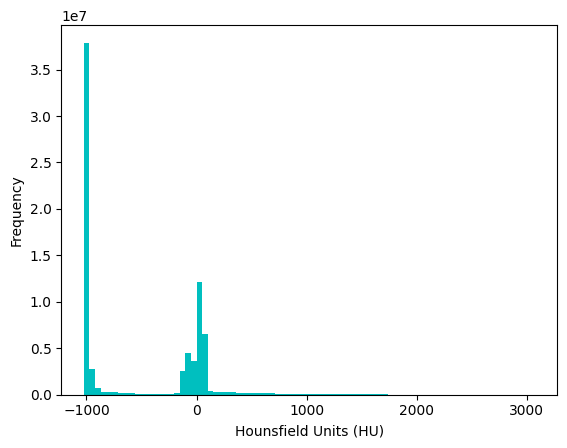

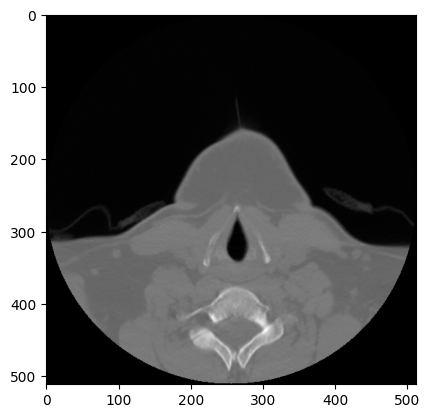

In [21]:
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[0], cmap=plt.cm.gray)
plt.show()

In [22]:
pix_resampled, spacing = resample(first_patient_pixels, slices, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

/tmp/ipykernel_990924/2981627436.py:13: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (297, 512, 512)
Shape after resampling	 (186, 226, 226)


In [23]:
point_cloud=get_open3d_pc(pix_resampled, 400, True)

Point cloud saved to CT_point_cloud.ply


In [24]:
print_point_cloud_range(point_cloud)

X-axis range: min = 21.940750122070312, max = 220.04183959960938
Y-axis range: min = 15.132418632507324, max = 224.24948120117188
Z-axis range: min = 0.0, max = 185.0


In [25]:
print(slices[-1].ImageOrientationPatient)
print(slices[-1].ImagePositionPatient)

[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
[-119.905, -127.572, -175.652]


In [26]:
image_orientation = slices[-1].ImageOrientationPatient
image_position = slices[-1].ImagePositionPatient

transformed_point_cloud, transformation_matrix = transform_point_cloud(point_cloud, image_orientation, image_position)

o3d.visualization.draw_geometries([transformed_point_cloud])

TrasnsMatrix is: 
 [[  -1.      -0.      -0.     119.905]
 [  -0.      -1.      -0.     127.572]
 [   0.       0.       1.    -175.652]
 [   0.       0.       0.       1.   ]]


In [27]:
print_point_cloud_range(transformed_point_cloud)

X-axis range: min = -100.13683959960937, max = 97.96424987792969
Y-axis range: min = -96.67748120117187, max = 112.43958136749268
Z-axis range: min = -175.652, max = 9.348000000000013


In [28]:
transformation_matrix, transformation_matrix_inv = get_transform_matrix(image_orientation, image_position)

TrasnsMatrix is: 
 [[  -1.      -0.      -0.     119.905]
 [  -0.      -1.      -0.     127.572]
 [   0.       0.       1.    -175.652]
 [   0.       0.       0.       1.   ]]


In [31]:
point_name='N'
vis_marked_point(point_cloud, point_name, transformation_matrix_inv)